Verwendete Version:<br>
Jupyter 6.1.4<br>
Python 3.8.6<br>
Matplotlib 3.3.2<br>
numpy 1.19.2<br>
pandas 1.1.3<br>
seaborn 0.11.0

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
import warnings

# SETUP<br>
Hier wird alles vorbereitet.

In [2]:

warnings.filterwarnings('ignore')

housing_data = pd.read_csv('DatenAusgegeben1.2_UTF8_manuell.csv', sep=";", keep_default_na=False)
print(housing_data.keys())


# Bereinigung und Feature Engeneering

# für €/qm² für besseren Vergleich der Daten
housing_data["Preisproqm"] = housing_data["Preis"]/housing_data["Wohnflaeche in qm"]

# monate seit 2136
housing_data["Monate"] = (housing_data["Verkaufsjahr"]-2136)*12 + housing_data["Verkaufsmonat"] -1

# Werte der Heizungsqualitaet in Zahlen umwandeln
housing_data["Heizungsqualitaet"] = [1 if x=="Schl" else 2 if x=="Ud" else 3 if x=="Ty" else 4 if x=="Gut" else 5 for x in housing_data["Heizungsqualitaet"]]

# Zustand, 1-10 wird auf 1-5 gemapt, das ist zwar ein bisschen ungenauer, aber einfacher zu vergleichen
housing_data["Zustandf"] = [int(x/2) + x%2 for x in housing_data["Zustand"]]

# Alle Zustände werden von 1...X auf 0....X-1 geschoben
housing_data["HeizungsqualitaetN"] = [ x-1 for x in housing_data["Heizungsqualitaet"]]
housing_data["ZustandN"] = [ x-1 for x in housing_data["Zustandf"]]
housing_data["FassadeN"] = [ x-1 for x in housing_data["Zustand Fassade"]]
housing_data["KuecheN"] = [ x-1 for x in housing_data["Kuechenqualitaet"]]

# NA in Garage Typ wird zu "Keine Garage"
housing_data["Garage Typ"] = ['keine Garage' if x=='NA' else x for x in housing_data["Garage Typ"]]


Index(['Grundstueck in qm', 'Grundstuecksform', 'Steigung', 'Bezirk', 'Zone',
       'Lage', 'Typ', 'Zustand', 'Gebaut', 'Renoviert', 'Zustand Fassade',
       'Kellerflaeche in qm', 'Heizung', 'Heizungsqualitaet', 'Klimaanlage',
       'Erster Stock in qm', 'Zweiter Stock in qm', 'Wohnflaeche in qm',
       'Schlafzimmer', 'Kuechen', 'Kuechenqualitaet', 'Raeume', 'Garage Typ',
       'Garagenkapazitaet', 'Pool', 'Verkaufsmonat', 'Verkaufsjahr', 'Preis'],
      dtype='object')


# Data Exploration
Im ersten Schritt des Projekts sollen die Daten untersucht und grundlegende Erkentnisse daraus gewonnen werden. Besonderer Fokus wird dabei auf die Qualitätskriterien und ihrem Einfluss auf den Verkaufspreis gelegt. Zuerst werden hierfür alle Daten insgesamt betrachtet und im Anschluss besondere Erkenntnisse herausgestellt. In der Analyse wird statt dem Verkaufspreis überwiegend der Preis pro Quadratmeter verwendet, da die Wohnfläche den größten Einfluss auf den Verkaufspreis hat und es so einfacher ist, die Daten zu vergleichen.
In bei der Modellbildung wird der Preis pro Qm nicht mehr benutzt, weil hier die Dimension Wohnfläche einfach im Modell eingebunden werden kann.

# Heizungstypen und ihre Qualität

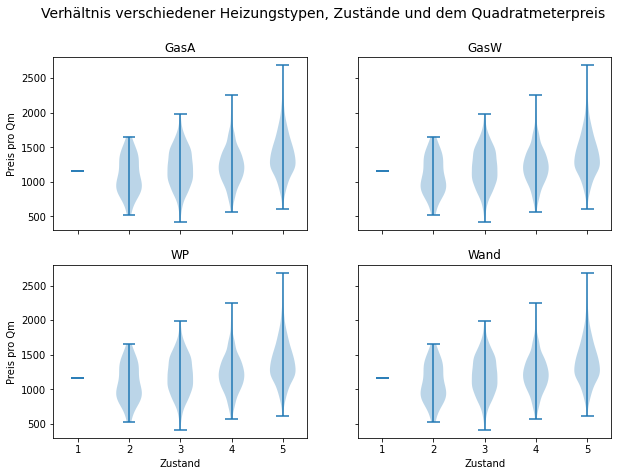

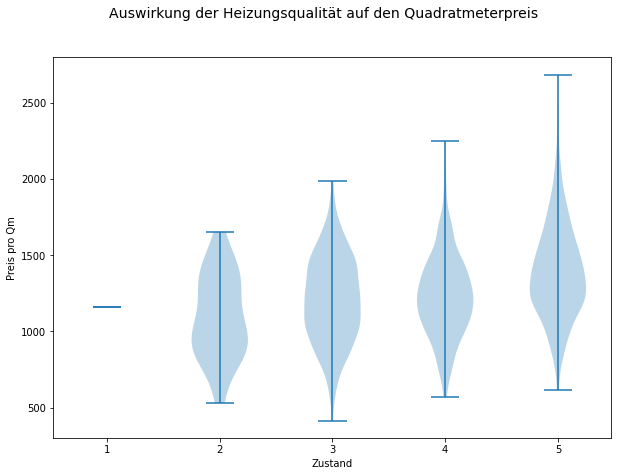

In [3]:
heater_types = housing_data["Heizung"].unique()
heater_quality = np.sort(housing_data["Heizungsqualitaet"].unique())
heater_data = [None]*(len(heater_types)+1)

fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10,7))
fig.suptitle("Verhältnis verschiedener Heizungstypen, Zustände und dem Quadratmeterpreis", fontsize=14)

for i in range(len(heater_types)):
    for l in range(len(heater_quality)):
        heater_data[l] = housing_data[housing_data["Heizungsqualitaet"] == heater_quality[l]]["Preisproqm"]
    
    axs[int(i/2),i%2].violinplot(heater_data)
    axs[int(i/2),i%2].set_title(heater_types[i])
    if i > 1:
        axs[int(i/2),i%2].set_xlabel("Zustand")
    if i%2 == 0:
        axs[int(i/2),i%2].set_ylabel("Preis pro Qm")
plt.show()   


plt.figure(figsize=(10,7))
for l in range(len(heater_quality)):
    heater_data[l] = housing_data[housing_data["Heizungsqualitaet"] == heater_quality[l]]["Preisproqm"]
plt.violinplot(heater_data, heater_quality)
plt.suptitle("Auswirkung der Heizungsqualität auf den Quadratmeterpreis",fontsize=14)
plt.xlabel("Zustand")
plt.ylabel("Preis pro Qm")
plt.show()

Nur für die GasA Heizung existieren genügend Daten für eine sinnvolle Untersuchung. Auch hat die Qualität der Heizung nur bei GasA annähernd einen Einfluss, die Heizungsqualitaet insgesamt hat keinen großen Einfluss auf den €/m².

# Erster Stock in Qm, Zweiter Stock in Qm und die Wohnfläche in Qm

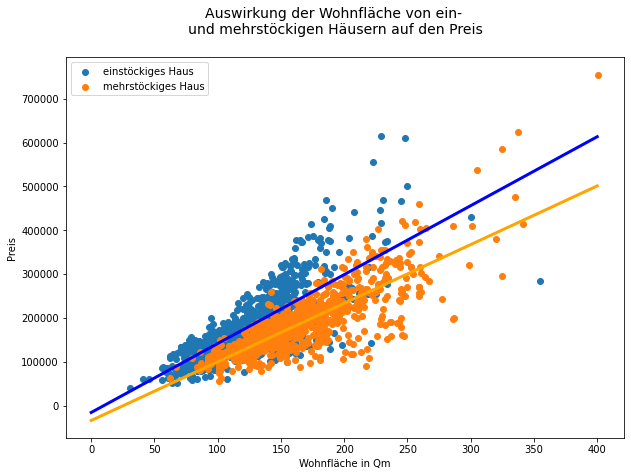

In [4]:
one_floor = housing_data[housing_data["Zweiter Stock in qm"] == 0 ]
two_floors = housing_data[housing_data["Zweiter Stock in qm"] != 0 ]


coef = np.polyfit(one_floor["Wohnflaeche in qm"],one_floor["Preis"],1)
poly1d_fn = np.poly1d(coef) 

coef1 = np.polyfit(two_floors["Wohnflaeche in qm"],two_floors["Preis"],1)
poly1d_fn1 = np.poly1d(coef1) 
x = np.linspace(0, 400, 10)

plt.figure(figsize=(10,7))
plt.scatter(one_floor["Wohnflaeche in qm"],one_floor["Preis"], label="einstöckiges Haus")
plt.scatter(two_floors["Wohnflaeche in qm"],two_floors["Preis"], label="mehrstöckiges Haus")
plt.plot(x, poly1d_fn(x), c="blue", linewidth=3)
plt.plot(x, poly1d_fn1(x), c="orange", linewidth=3)

plt.suptitle("Auswirkung der Wohnfläche von ein- \nund mehrstöckigen Häusern auf den Preis",fontsize=14)
plt.xlabel("Wohnfläche in Qm")
plt.ylabel("Preis")
plt.legend()
plt.show()

Es gibt keine Spalte in den Daten, welche die Anzahl der Stockwerke beschreibt, weshalb nur ein oder zwei Stockwerke erkannt werden können. Wenn die Fläche des ersten Stockwerks der Wohnfläche entspricht, kann es nur ein Stockwerk geben, sonst sind es mindestens zwei. Preislich gibt es größere Unterschiede, so ist der Preis von einstöckigen Häusern durchschnittlich 50.000 GC Dollar höher, als der von zweistöckigen. Hier könnte aber die größere Grundstücksfläche einen Einfluss haben.

# Schlafzimmer, Küchen und die Anzahl der Räume

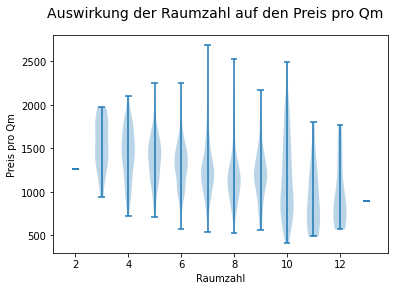

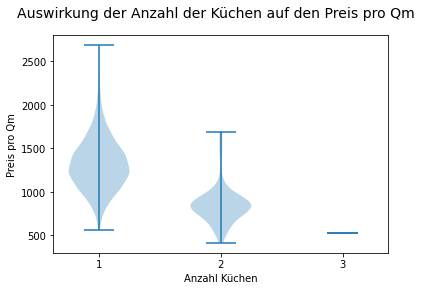

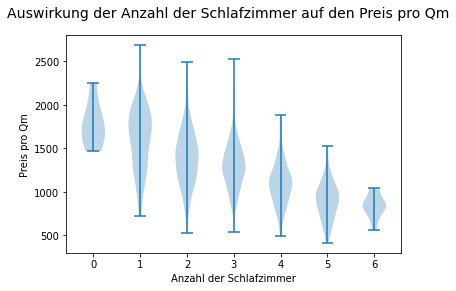

In [5]:
rooms = np.sort(housing_data["Raeume"].unique())
room_data = [None]*len(rooms)
for i in range(len(rooms)):
    room_data[i] = housing_data[housing_data["Raeume"] == rooms[i]]["Preisproqm"]


plt.violinplot(room_data, rooms)
plt.suptitle("Auswirkung der Raumzahl auf den Preis pro Qm",fontsize=14)
plt.xlabel("Raumzahl")
plt.ylabel("Preis pro Qm")
plt.show()


kitchens = np.sort(housing_data["Kuechen"].unique())
kitchen_data = [None]*len(kitchens)
for i in range(len(kitchens)):
    kitchen_data[i] = housing_data[housing_data["Kuechen"] == kitchens[i]]["Preisproqm"]

plt.violinplot(kitchen_data, kitchens)
plt.suptitle("Auswirkung der Anzahl der Küchen auf den Preis pro Qm",fontsize=14)
plt.xlabel("Anzahl Küchen")
plt.xticks([1,2,3])
plt.ylabel("Preis pro Qm")
plt.show()


bedrooms = np.sort(housing_data["Schlafzimmer"].unique())
bedroom_data = [None]*len(bedrooms)
for i in range(len(bedrooms)):
    bedroom_data[i] = housing_data[housing_data["Schlafzimmer"] == bedrooms[i]]["Preisproqm"]

plt.violinplot(bedroom_data, bedrooms)
plt.suptitle("Auswirkung der Anzahl der Schlafzimmer auf den Preis pro Qm",fontsize=14)
plt.xlabel("Anzahl der Schlafzimmer")
plt.ylabel("Preis pro Qm")
plt.show()

Wie in den Graphen zu sehen ist, ist die Anzahl von Küchen und Schlafzimmern nicht sehr aussagekräftig. Zu erwarten ist, dass der Preis pro Qm mit der Anzahl der Räume positiv korreliert. Entgegen der Erwartung ist der Preis niedriger, was darauf hindeutet, das hier eine negative Korrelation besteht.

# Garagentyp und  Garagenkapazität

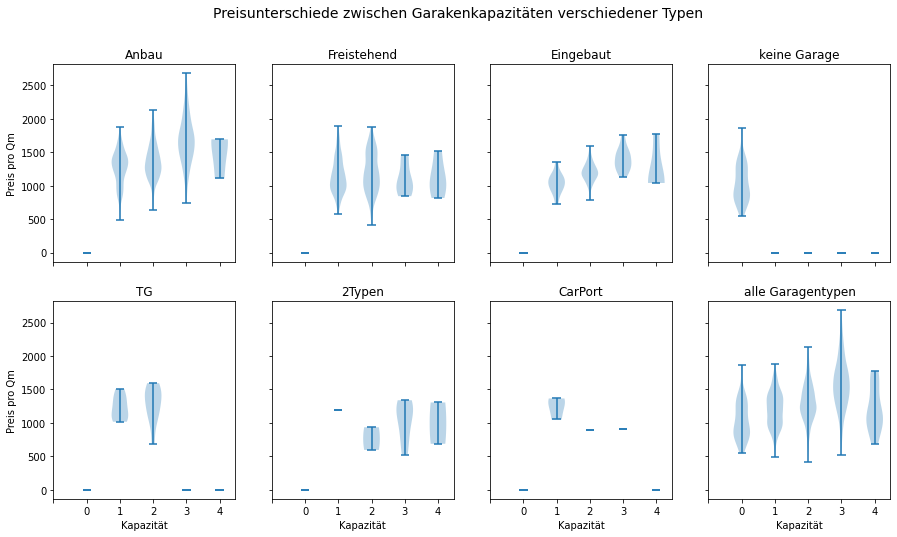

In [6]:
garage_types = housing_data["Garage Typ"].unique()


fig, axs = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(15,8))

for i in range(len(garage_types)):
    type_data = housing_data[housing_data["Garage Typ"] == garage_types[i]]
    garage_capacity = [0,1,2,3,4]
    garage_data = [0]*(len(garage_capacity))
    
    for l in garage_capacity:
        garage_data[l] = type_data[housing_data["Garagenkapazitaet"] == l]["Preisproqm"].values.tolist()
        if garage_data[l] == []:
            garage_data[l] = [0]
            # Ich habe keine bessere Umsetzung gefunden, Recherche hat auch nicht weitergeholfen
            # jetzt ist überall mindestens ein Dummywert [0] drinnen -.-
            # das ist sogar richtig
            
    axs[int(i/4),i%4].violinplot(garage_data)
    axs[int(i/4),i%4].set_title(garage_types[i])
    
    
garage_capacity = np.sort(housing_data["Garagenkapazitaet"].unique())
garage_data = [0]*(len(garage_capacity))
for i in range(len(garage_capacity)):
    garage_data[i] = housing_data[housing_data["Garagenkapazitaet"] == garage_capacity[i]]["Preisproqm"]


axs[1,3].violinplot(garage_data)
axs[1,3].set_title("alle Garagentypen")
fig.suptitle("Preisunterschiede zwischen Garakenkapazitäten verschiedener Typen", fontsize=14)

for i in range(8):
    plt.sca(axs[int(i/4),i%4])
    plt.xticks(range(6), ["","0","1","2","3","4"])
    if i > 3:
        plt.xlabel("Kapazität")
    if i % 4 == 0:
        plt.ylabel("Preis pro Qm")

    #das funktioniert, aber wieso?? wieso ["","0",..?
plt.show()

Im Folgenden wurde untersucht, in wiefern sich Garagentyp und -kapazität auf den Preis pro Qm auswirken. Dabei wurden die Garagen nach ihren Typen aufgeteilt und die Anzahl der Stellplätze mit dem Quadratmeterpreis verglichen. Bei allen Garagentypen zeichnet sich ein Anstieg des Quadratmeterpreises zwischen ein und drei Garagenplätzen ab. Auch sind Häuser mit Garage teurer als Häuser ohne Garage. Erstaunlicherweise leigt der Preis pro Quadratmeter für vier Stellplätze deutlich niedriger, als der für drei.

# Verkaufsmonat, Verkaufsjahr und Preis

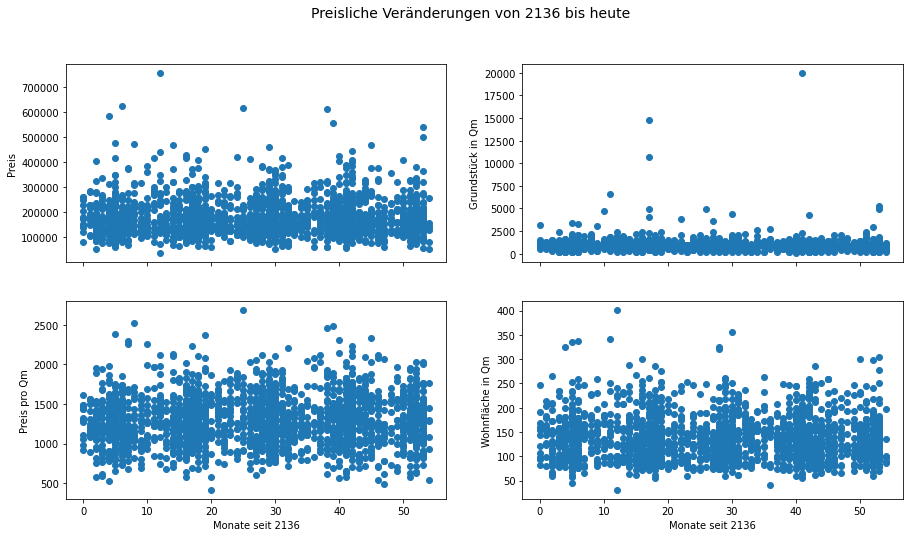

In [7]:
fig, axs = plt.subplots(2, 2, sharex=True, figsize=(15,8))

axs[0,0].scatter(housing_data["Monate"],housing_data["Preis"])
axs[0,0].set_ylabel("Preis")
axs[0,1].scatter(housing_data["Monate"],housing_data["Grundstueck in qm"])
axs[0,1].set_ylabel("Grundstück in Qm")
axs[1,0].scatter(housing_data["Monate"],housing_data["Preisproqm"])
axs[1,0].set_ylabel("Preis pro Qm")
axs[1,0].set_xlabel("Monate seit 2136")
axs[1,1].scatter(housing_data["Monate"],housing_data["Wohnflaeche in qm"])
axs[1,1].set_ylabel("Wohnfläche in Qm")
axs[1,1].set_xlabel("Monate seit 2136")
# TODO Skala anpassen xlabel
# TODO Titel
fig.suptitle("Preisliche Veränderungen von 2136 bis heute",fontsize=14)

plt.show()

Bei der Betrachtung von Verkaufspreisen und Verkaufszeit wird erwartet, dass sich der Preis zwischen verschiedenen Monaten weniger unterscheidet, als zwischen Jahren. Entgegen den Erwartungen gibt es durchaus starke Schwankungen der Verkaufspreise innerhalb eines Jahres. Im Sommer werden häufig teure und große Häuser verkauft. Auch ist die Anzahl der Verkäufe deutlich höher als in den Wintermonaten. Das Jahr des Verkaufs hat dabei aber nur einen geringeren Einfluss auf den Preis.

# Heizungsqualität, Küchenqualität, Fassadenqualität und Zustand


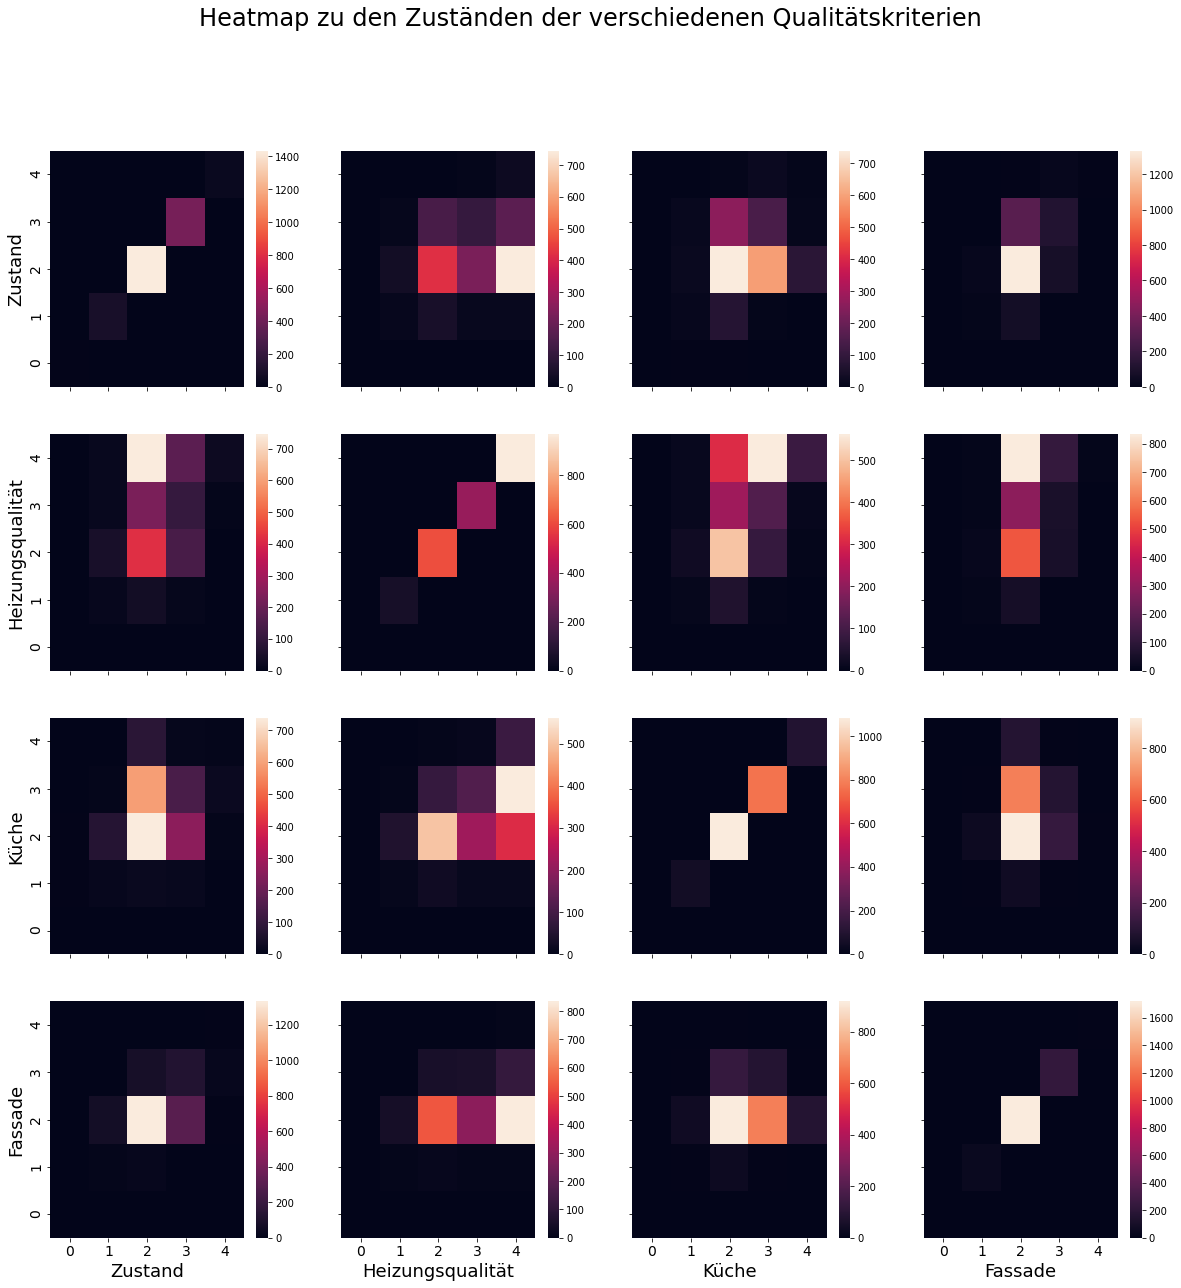

In [8]:
# Daten vorbereiten für heatmap: im Besten Fall sollte eine Diagonale von Links unten -> rechts oben gehen
# Achtung Rechenintensiv!
keys = ["ZustandN", "HeizungsqualitaetN", "KuecheN", "FassadeN"]


fig, axs = plt.subplots(len(keys), len(keys), sharex=True, sharey=True, figsize=(20,20))
fig.suptitle("Heatmap zu den Zuständen der verschiedenen Qualitätskriterien",fontsize=24)
# Zweimal über Keys iterieren -> key1 X key2 Plots (key1 == key2)
# für jeden Plot alle Möglichen Werte von key1 heraussuchen -> X-Achse
# für jeden möglichen X-Wert alle Y-Werte von key2 in data schreiben
# happy plotting
for i in range(len(keys)):
    values = [0,1,2,3,4]
    for l in range(len(keys)):
        
        data = [None]*len(values)
        for f in range(len(values)):
            data[f] = [0]*len(values)
        data[1][1] = 2
        for value in values:
            raw_data = housing_data[housing_data[keys[i]] == value][keys[l]]
            unique, counts = np.unique(raw_data, return_counts=True)
            count = dict(zip(unique, counts))
            for key in count.keys():
                # Es tut mir ja leid
                data[value][key] = count[key]
        sb.heatmap(data, ax = axs[i,l]) #vmin=0, vmax=16000, center=8000
        axs[i,l].invert_yaxis()
        plt.sca(axs[i,l])
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        # Hm, vllt gibts da auch nen besseren Weg
        if i == len(keys)-1:
            axs[i,l].set_xlabel(str(keys[l][:-1]).replace("ae","ä").replace("ue","ü"), fontsize=18)
        if l == 0:
            axs[i,l].set_ylabel(str(keys[i][:-1]).replace("ae","ä").replace("ue","ü"), fontsize=18)


Bei der Betrachtung der Qualitätskriterien für Heizung, Küche, Fassade und Zustand des Hauses wurden einige Korrelationen festgestellt:
* alle Kriterien haben nur sehr wenige schlechte Bewertungen
* durchschnittliche Bewertungen haben eine recht hohe Korrelation
* bei besserern Bewertungen schweifen die Werte öfter ab, sodass keine Korrelation vorliegt.

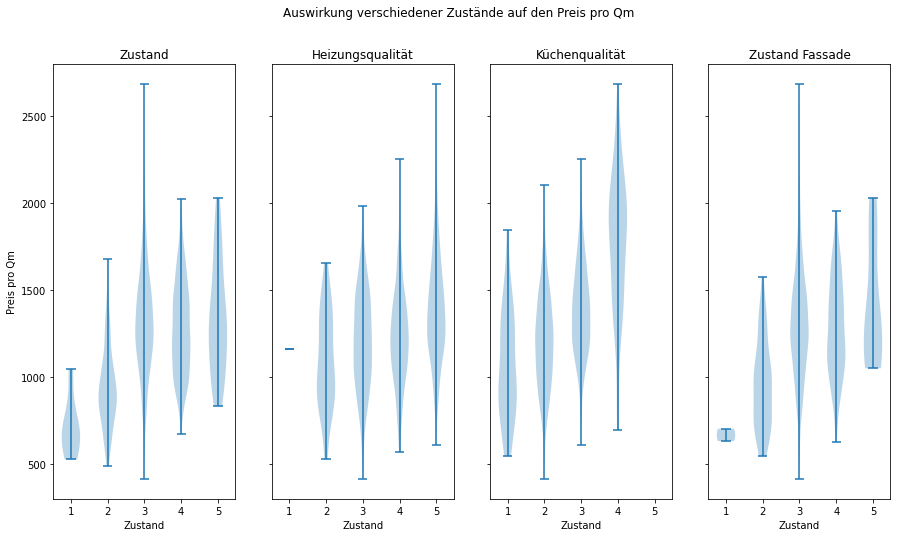

[3 4 2 5]


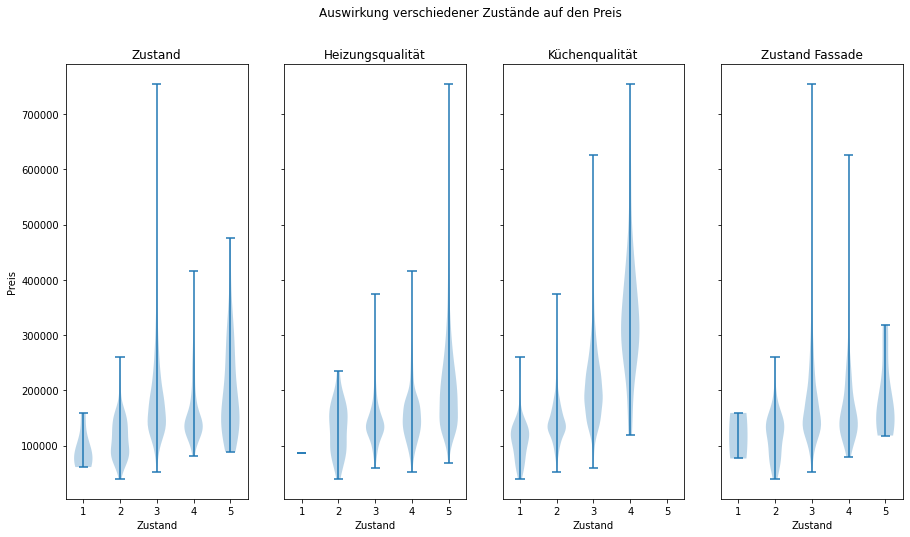

[3 4 2 5]


In [9]:
keys = ["Zustandf", "Heizungsqualitaet", "Kuechenqualitaet", "Zustand Fassade"]
keysx = ["Zustand", "Heizungsqualität", "Küchenqualität", "Zustand Fassade"]

rows = ["Preisproqm", "Preis"]
rowsx = ["Preis pro Qm", "Preis"]
for f in range(len(rows)):
    fig, axs = plt.subplots(1, len(keys), sharex=True, sharey=True, figsize=(15,8))
    for x in range(len(keys)):
        quality = np.sort(housing_data[keys[x]].unique())
        data = [None]*len(quality)
        for i in range(len(quality)):
            data[i] = housing_data[housing_data[keys[x]] == quality[i]][rows[f]]
        axs[x].violinplot(data)
        axs[x].set_title(str(keysx[x]))
        axs[x].set_xticks([1,2,3,4,5])
        axs[x].set_xlabel("Zustand")
        if x == 0:
            axs[x].set_ylabel(rowsx[f])
    
    fig.suptitle("Auswirkung verschiedener Zustände auf den " + rowsx[f])
    plt.show()
    
    #TODO: Küche hat kein sehr schlecht!
    print(housing_data["Kuechenqualitaet"].unique())

Mit dieser schwachen Korrelation zwischen den Qualitätskriterien können Einflüsse auf den Quadratmeterpreis von anderen Kriterien ausgeschlossen werden und eine differenzierte Analyse wird möglich. Deutlich ist hier zu sehen, dass bei besserer Qualitätsstufe der Preis ansteigt. Besonders stark ist der Effekt bei der Küchenqualität zu sehen, hier kann sich der Preis pro Qm mitunter verdoppeln. Bei allen anderen Qualitätsmerkmalen ist dieser Effekt auch erkennbar, wenn auch deutlich schwächer.

# Grundstücksform

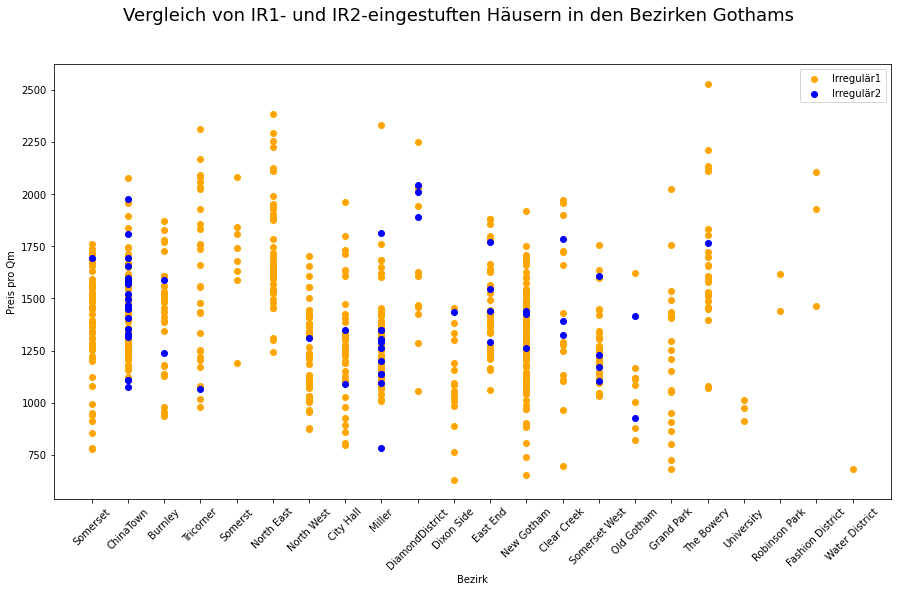

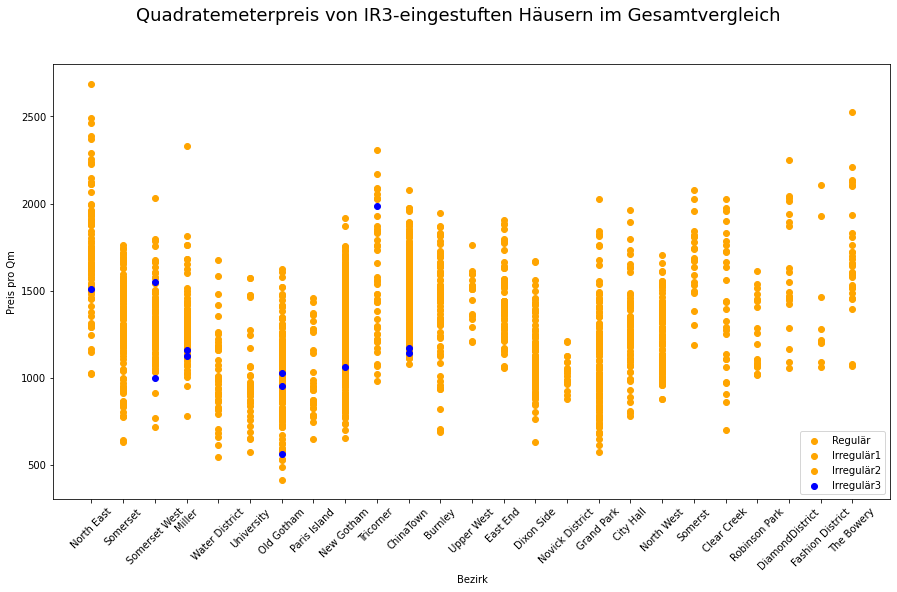

In [10]:
house_reg = housing_data[housing_data.Grundstuecksform == "Reg"]
house_ir1 = housing_data[housing_data.Grundstuecksform == "IR1"]
house_ir2 = housing_data[housing_data.Grundstuecksform == "IR2"]
house_ir3 = housing_data[housing_data.Grundstuecksform == "IR3"]

plt.figure(figsize=(15,8))
plt.scatter(house_ir1["Bezirk"],house_ir1["Preis"]/house_ir1["Wohnflaeche in qm"], c="orange")
plt.scatter(house_ir2["Bezirk"],house_ir2["Preis"]/house_ir2["Wohnflaeche in qm"], c="blue")


plt.suptitle("Vergleich von IR1- und IR2-eingestuften Häusern in den Bezirken Gothams",fontsize=18)
plt.xlabel("Bezirk")
plt.ylabel("Preis pro Qm")
plt.legend(["Irregulär1", "Irregulär2"])
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(15,8))
plt.scatter(house_reg["Bezirk"],house_reg["Preis"]/house_reg["Wohnflaeche in qm"], c="orange")
plt.scatter(house_ir1["Bezirk"],house_ir1["Preis"]/house_ir1["Wohnflaeche in qm"], c="orange")
plt.scatter(house_ir2["Bezirk"],house_ir2["Preis"]/house_ir2["Wohnflaeche in qm"], c="orange")
plt.scatter(house_ir3["Bezirk"],house_ir3["Preis"]/house_ir3["Wohnflaeche in qm"], c="blue")


plt.suptitle("Quadratemeterpreis von IR3-eingestuften Häusern im Gesamtvergleich",fontsize=18)
plt.xlabel("Bezirk")
plt.ylabel("Preis pro Qm")
plt.legend(["Regulär", "Irregulär1", "Irregulär2", "Irregulär3"])
plt.xticks(rotation=45)
plt.show()

Bei der Grundstücksform lässt sich absehen, dass Häuser der Form IR1 meist teurer sind als diese der Form IR2. 
Bei Häusern der Form IR3 handelt es sich meist um billigere Häuser, als bei den anderen Grundstücksformen.

# Steigung

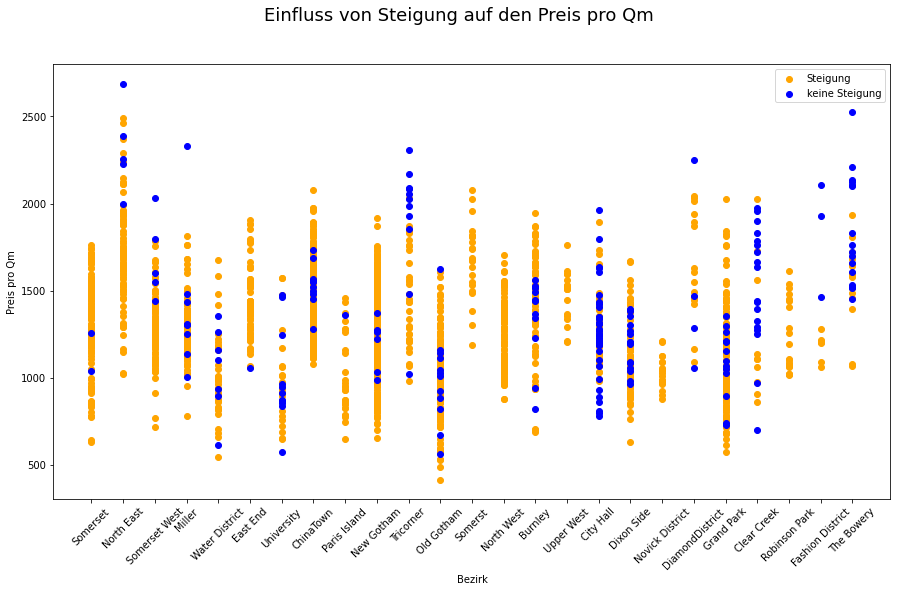

In [11]:
house_evelation = housing_data[housing_data.Steigung == "Ja"]
house_no_evelation = housing_data[housing_data.Steigung == "Nein"]

plt.figure(figsize=(15,8))
plt.scatter(house_no_evelation["Bezirk"],house_no_evelation["Preis"]/house_no_evelation["Wohnflaeche in qm"], c="orange")
plt.scatter(house_evelation["Bezirk"],house_evelation["Preis"]/house_evelation["Wohnflaeche in qm"], c="blue")

plt.suptitle("Einfluss von Steigung auf den Preis pro Qm",fontsize=18)
plt.xlabel("Bezirk")
plt.ylabel("Preis pro Qm")
plt.legend(["Steigung", "keine Steigung"])
plt.xticks(rotation=45)
plt.show()


#TODO wie sie sehen, sehen sie nüschtsch! -> violonplot

# Bezirke

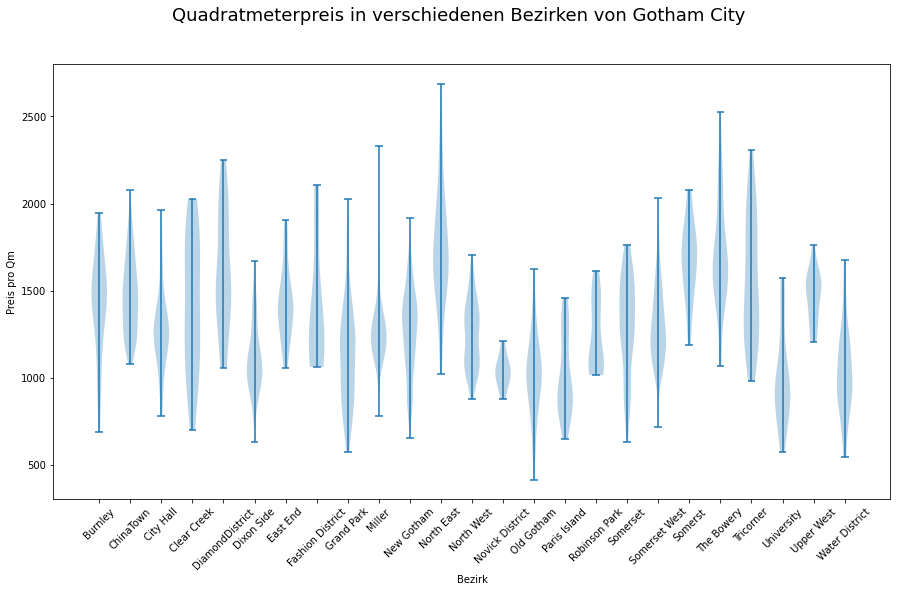

In [12]:
key = "Bezirk"
rows = ["Preisproqm"]
quality = np.sort(housing_data[key].unique())

for row in rows:
    fig= plt.figure(figsize=(15,8))
    data = [None]*len(quality)
    for i in range(len(quality)):
        data[i] = housing_data[housing_data[key] == quality[i]][row]

    plt.violinplot(data)
    plt.suptitle("Quadratmeterpreis in verschiedenen Bezirken von Gotham City",fontsize=18)
    plt.xlabel("Bezirk")
    plt.ylabel("Preis pro Qm")
    plt.xticks(np.arange(len(quality)) + 1, quality, rotation=45)
    
    plt.show()

In den unterschiedlichen Bezirken werden Immobilien zu unterschiedlichen Preisen gehandelt, so unterscheiden sich die günstigsten als auch die teuersten Immobilien sowie der Preisspiegel.  

# Zone

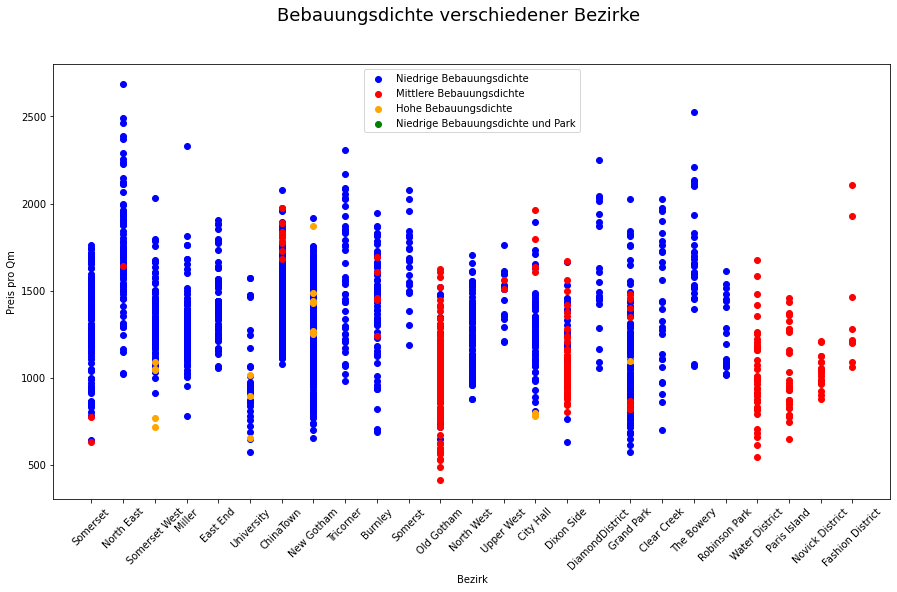

In [13]:
house_rh = housing_data[housing_data.Zone == "RH"]
house_rl = housing_data[housing_data.Zone == "RL"]
house_rp = housing_data[housing_data.Zone == "RP"]
house_rm = housing_data[housing_data.Zone == "RM"]

plt.figure(figsize=(15,8))
plt.scatter(house_rl["Bezirk"],house_rl["Preis"]/house_rl["Wohnflaeche in qm"], c="blue")
plt.scatter(house_rm["Bezirk"],house_rm["Preis"]/house_rm["Wohnflaeche in qm"], c="red")
plt.scatter(house_rh["Bezirk"],house_rh["Preis"]/house_rh["Wohnflaeche in qm"], c="orange")
plt.scatter(house_rp["Bezirk"],house_rp["Preis"]/house_rp["Wohnflaeche in qm"], c="green")



plt.suptitle("Bebauungsdichte verschiedener Bezirke",fontsize=18)
plt.xlabel("Bezirk")
plt.ylabel("Preis pro Qm")
plt.xticks(rotation=45)
plt.legend(["Niedrige Bebauungsdichte", "Mittlere Bebauungsdichte",
            "Hohe Bebauungsdichte","Niedrige Bebauungsdichte und Park"])
plt.show()

In Gotham gibt es kaum Immobilien, welche sich in einer hohen Bebauungsdichte befinden und keine, welche sich in einer niedrigen Bebauungsdichte und bei einem Park befinden.<br>
In den Bezirken Miller, East End, Tricorner, Somerst, North West, Diamond District, Clear Creek, The Bowery und Robinson Park stehen Häuser nur in einer geringen Bebauungsdichte.<br>
Dagegen gibt es in den Bezirken Water District, Paris Island, Novick Distric und Fashion District nur Häuser in mittlerer Bebauungsdichte.<br>
Häuser in Gegenden mit hoher Bebauungsdichte gibt es kaum.<br>
Gotham ist keine Stadt, die stark bebaut ist. 

# Lage

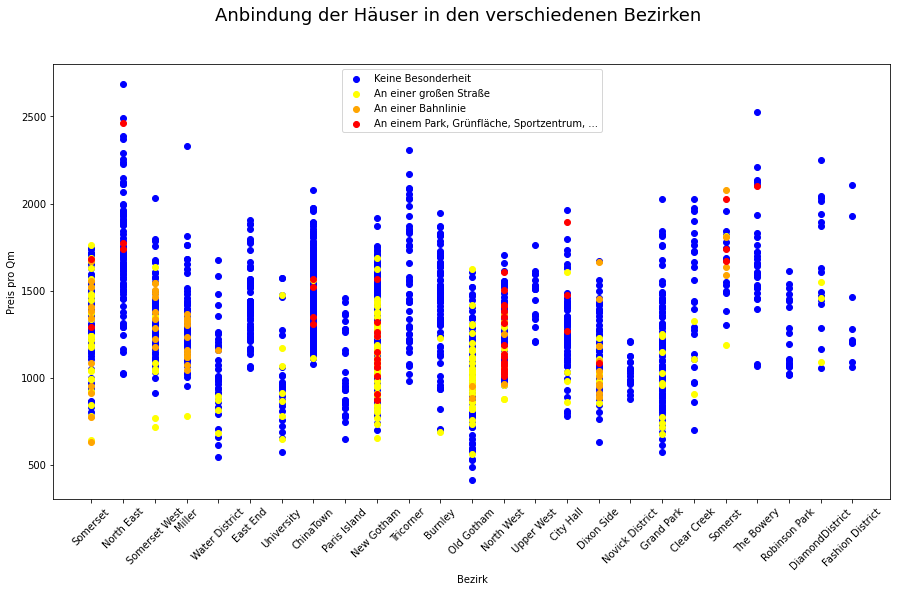

In [14]:
house_straße = housing_data[housing_data.Lage == "Str"]
house_bahn = housing_data[housing_data.Lage == "Bahn"]
house_park = housing_data[housing_data.Lage == "Pos"]
house_normal = housing_data[housing_data.Lage == "Norm"]

plt.figure(figsize=(15,8))
plt.scatter(house_normal["Bezirk"],house_normal["Preis"]/house_normal["Wohnflaeche in qm"], c="blue")
plt.scatter(house_straße["Bezirk"],house_straße["Preis"]/house_straße["Wohnflaeche in qm"], c="yellow")
plt.scatter(house_bahn["Bezirk"],house_bahn["Preis"]/house_bahn["Wohnflaeche in qm"], c="orange")
plt.scatter(house_park["Bezirk"],house_park["Preis"]/house_park["Wohnflaeche in qm"], c="red")

plt.suptitle("Anbindung der Häuser in den verschiedenen Bezirken",fontsize=18)
plt.xlabel("Bezirk")
plt.ylabel("Preis pro Qm")
plt.xticks(rotation=45)
plt.legend(["Keine Besonderheit", "An einer großen Straße",
            "An einer Bahnlinie","An einem Park, Grünfläche, Sportzentrum, ..."])
plt.show()

Mit Außnahme von Old Gotham lässt sich sagen, dass Häuser in der Nähe von Bahnlinien und Parks teurer sind, als Häuser nahe einer großen Straße.<br>
Des weiteren gibt es in den Bezirken East End, Paris Island, Tricorner, Upper West, Novick District Robinson Park, Fashion District keine Häuser, die sich in der Nähe von Bahnlinien, großen Straßen oder Parks befinden.

# Haustyp und Klimaanlage

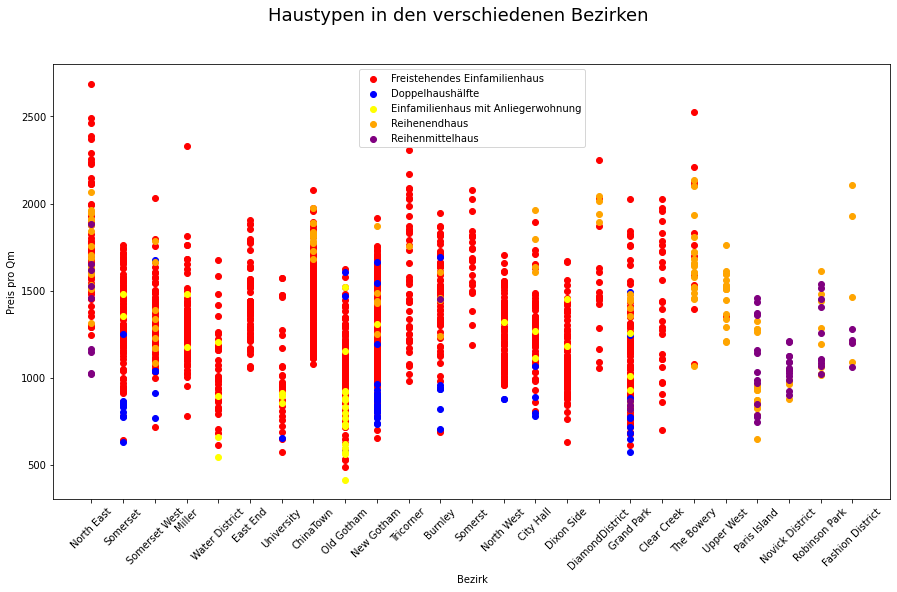

Reihenhäuser haben immer Klimaanlagen:
 ['Y'] ['Y']


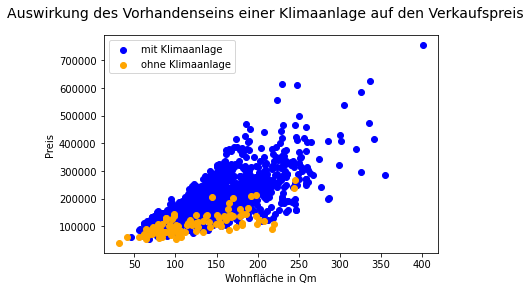

In [15]:
house_1fam = housing_data[housing_data.Typ == "1Fam"]
house_2fam = housing_data[housing_data.Typ == "2Fam"]
house_2faman = housing_data[housing_data.Typ == "2FamAn"]
house_reh = housing_data[housing_data.Typ == "REH"]
house_rmh = housing_data[housing_data.Typ == "RMH"]

plt.figure(figsize=(15,8))
plt.scatter(house_1fam["Bezirk"],house_1fam["Preis"]/house_1fam["Wohnflaeche in qm"], c="red")
plt.scatter(house_2fam["Bezirk"],house_2fam["Preis"]/house_2fam["Wohnflaeche in qm"], c="blue")
plt.scatter(house_2faman["Bezirk"],house_2faman["Preis"]/house_2faman["Wohnflaeche in qm"], c="yellow")
plt.scatter(house_reh["Bezirk"],house_reh["Preis"]/house_reh["Wohnflaeche in qm"], c="orange")
plt.scatter(house_rmh["Bezirk"],house_rmh["Preis"]/house_rmh["Wohnflaeche in qm"], c="purple")

plt.suptitle("Haustypen in den verschiedenen Bezirken",fontsize=18)
plt.xlabel("Bezirk")
plt.ylabel("Preis pro Qm")
plt.xticks(rotation=45)
plt.legend(["Freistehendes Einfamilienhaus", "Doppelhaushälfte",
            "Einfamilienhaus mit Anliegerwohnung","Reihenendhaus","Reihenmittelhaus"])

plt.show()

print("Reihenhäuser haben immer Klimaanlagen:\n", house_rmh["Klimaanlage"].unique(), house_reh["Klimaanlage"].unique())

house_ac = housing_data[housing_data.Klimaanlage == "Y"]
house_not_ac = housing_data[housing_data.Klimaanlage == "N"]
plt.scatter(house_ac["Wohnflaeche in qm"],house_ac["Preis"], c='blue')
plt.scatter(house_not_ac["Wohnflaeche in qm"],house_not_ac["Preis"],c="orange")

plt.suptitle("Auswirkung des Vorhandenseins einer Klimaanlage auf den Verkaufspreis",fontsize=14)
plt.xlabel("Wohnfläche in Qm")
plt.ylabel("Preis")
plt.legend(["mit Klimaanlage", "ohne Klimaanlage"])
plt.show()

In Gothem gibt es nur wenige 2-Familien-Anbau Häuser.<br> 
Die Bezirke Clear Creek & East End bestehen nur aus 1-Familien Häusern.<br>
Im Gegensatz dazu gibt es in den Bezirken Paris Island, Novick District, Robinson Park und Fashion District nur Reihenhäuser. Upper West besitzt bloß  Reihenendhäuser mit Außnahme eines einzigen ein 1-Familien Hauses.<br>
Zu Reihenhäusern ist zu sagen, dass diese nur mit Klimaanlage kommen.<br>
Klimaanlagen steigern den Wert einer Immobilie.

# Zustand

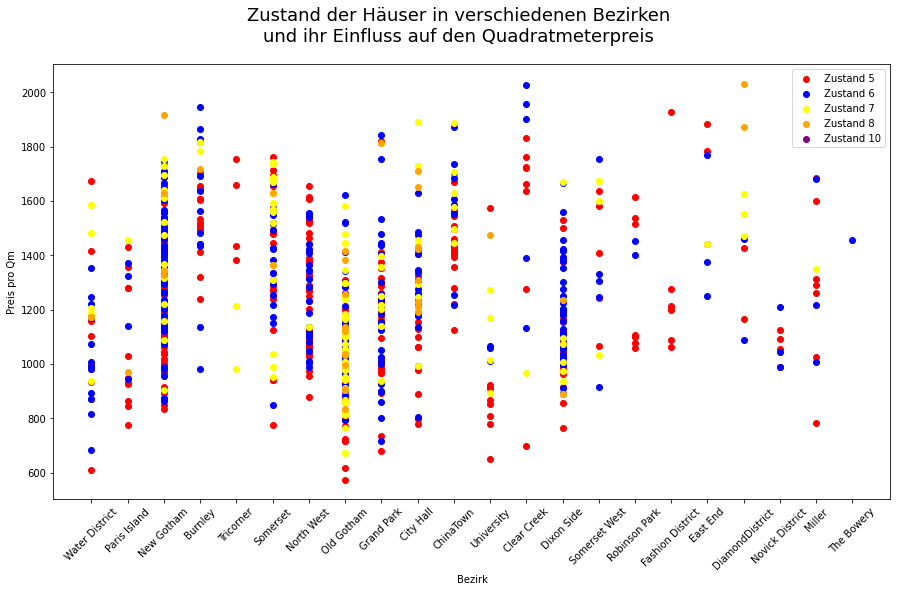

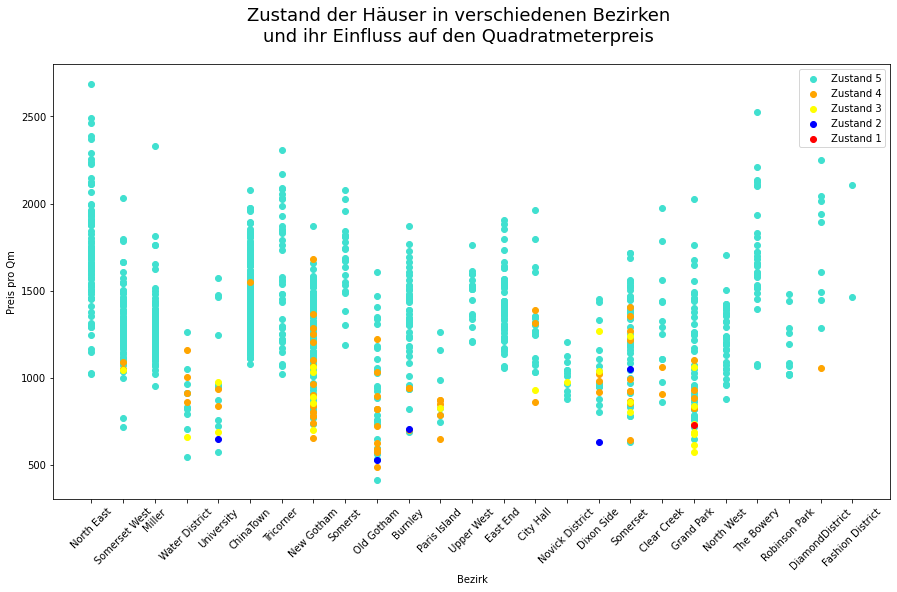

In [16]:
house_1 = housing_data[housing_data.Zustand == 1]
house_2 = housing_data[housing_data.Zustand == 2]
house_3 = housing_data[housing_data.Zustand == 3]
house_4 = housing_data[housing_data.Zustand == 4]
house_5 = housing_data[housing_data.Zustand == 5]
house_6 = housing_data[housing_data.Zustand == 6]
house_7 = housing_data[housing_data.Zustand == 7]
house_8 = housing_data[housing_data.Zustand == 8]
house_9 = housing_data[housing_data.Zustand == 9]
house_10 = housing_data[housing_data.Zustand == 10]

fig= plt.figure(figsize=(15,8))
plt.scatter(house_6["Bezirk"],house_6["Preis"]/house_6["Wohnflaeche in qm"], c="red")
plt.scatter(house_7["Bezirk"],house_7["Preis"]/house_7["Wohnflaeche in qm"], c="blue")
plt.scatter(house_8["Bezirk"],house_8["Preis"]/house_8["Wohnflaeche in qm"], c="yellow")
plt.scatter(house_9["Bezirk"],house_9["Preis"]/house_9["Wohnflaeche in qm"], c="orange")
plt.scatter(house_10["Bezirk"],house_10["Preis"]/house_10["Wohnflaeche in qm"], c="purple")

plt.suptitle("Zustand der Häuser in verschiedenen Bezirken\nund ihr Einfluss auf den Quadratmeterpreis",fontsize=18)
plt.xlabel("Bezirk")
plt.ylabel("Preis pro Qm")
plt.xticks(rotation=45)
plt.legend(["Zustand 5", "Zustand 6",
            "Zustand 7","Zustand 8","Zustand 10"])

plt.show()

fig= plt.figure(figsize=(15,8))
plt.scatter(house_5["Bezirk"],house_5["Preis"]/house_5["Wohnflaeche in qm"], c="turquoise")
plt.scatter(house_4["Bezirk"],house_4["Preis"]/house_4["Wohnflaeche in qm"], c="orange")
plt.scatter(house_3["Bezirk"],house_3["Preis"]/house_3["Wohnflaeche in qm"], c="yellow")
plt.scatter(house_2["Bezirk"],house_2["Preis"]/house_2["Wohnflaeche in qm"], c="blue")
plt.scatter(house_1["Bezirk"],house_1["Preis"]/house_1["Wohnflaeche in qm"], c="red")

plt.suptitle("Zustand der Häuser in verschiedenen Bezirken\nund ihr Einfluss auf den Quadratmeterpreis",fontsize=18)
plt.xlabel("Bezirk")
plt.ylabel("Preis pro Qm")
plt.xticks(rotation=45)
plt.legend(["Zustand 5", "Zustand 4",
            "Zustand 3","Zustand 2","Zustand 1"])
plt.show()

Eine deutliche Abhängigkeit von Immobilienpreis und -zustand lässt sich bei den Zuständen 5 und darunter erkennen.
Zwischen Zustand 6 und Zustand 10 ist eine solche Abhängigkeit nicht zu sehen.

# Baujahr und Renovation

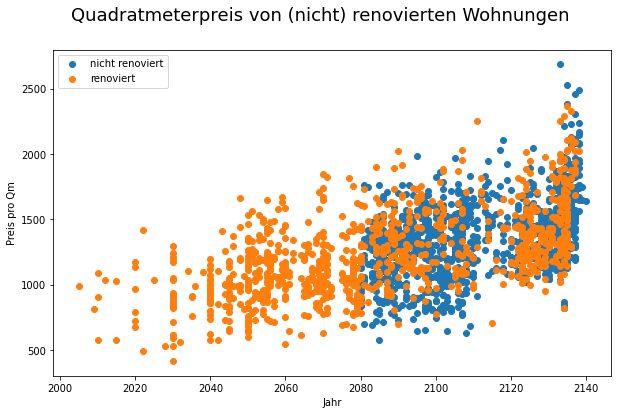

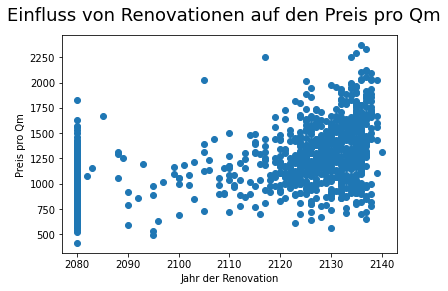

In [17]:
house_renovated = housing_data[housing_data.Gebaut != housing_data.Renoviert]
house_not_renovated = housing_data[housing_data.Gebaut == housing_data.Renoviert]

fig= plt.figure(figsize=(10,6))

plt.scatter(house_not_renovated["Gebaut"],house_not_renovated["Preis"]/house_not_renovated["Wohnflaeche in qm"])
plt.scatter(house_renovated["Gebaut"],house_renovated["Preis"]/house_renovated["Wohnflaeche in qm"])

plt.suptitle("Quadratmeterpreis von (nicht) renovierten Wohnungen ",fontsize=18)
plt.xlabel("Jahr")
plt.ylabel("Preis pro Qm")
plt.legend(["nicht renoviert", "renoviert"])
plt.show()

plt.scatter(house_renovated["Renoviert"],house_renovated["Preis"]/house_renovated["Wohnflaeche in qm"])
plt.suptitle("Einfluss von Renovationen auf den Preis pro Qm",fontsize=18)
plt.xlabel("Jahr der Renovation")
plt.ylabel("Preis pro Qm")
plt.show()

Der Preis pro Quadratmeter ist nur bei renovierten Häusern vom Baujahr/Renovationsjahr abhängig.<br>
Alle Häuser, die vor 2080 gebaut wurden, wurden renoviert.<br>
Häuser, die nach dem Jahr 2130 gebaut wurden, können um einiges teurer sein, als die Häuser, die in vorherigen Jahren gebaut worden sind.<br>
Preise von renovierten und unrenovierten Häusern unterscheiden sich nicht erkennbar voneinander.<br>
Im Jahr 2080 wurden besonders viele Häuser renoviert, entweder gab es in diesem Jahr eine Naturkatastrophe oder die Daten sind nicht richtig. Möglich ist, dass Joker eine Nachbarschaft verwüstet hat.
Wenn man diese Anomalie außenvor lässt, sieht man, dass die Anzahl der Renovationen ab 2080 über die Jahre kontinuierlich ansteigt.<br>
Nach 2110 werden fast keine Hauser günstiger als 100000 GC Dollar gebaut.<br>
Je später ein Haus gebaut wird, desto teurer ist es. Diese Steigung ist jedoch gering. Vermutlich entsteht diese Steigung Aufgrund von Inflation.

# Zustand Fassade

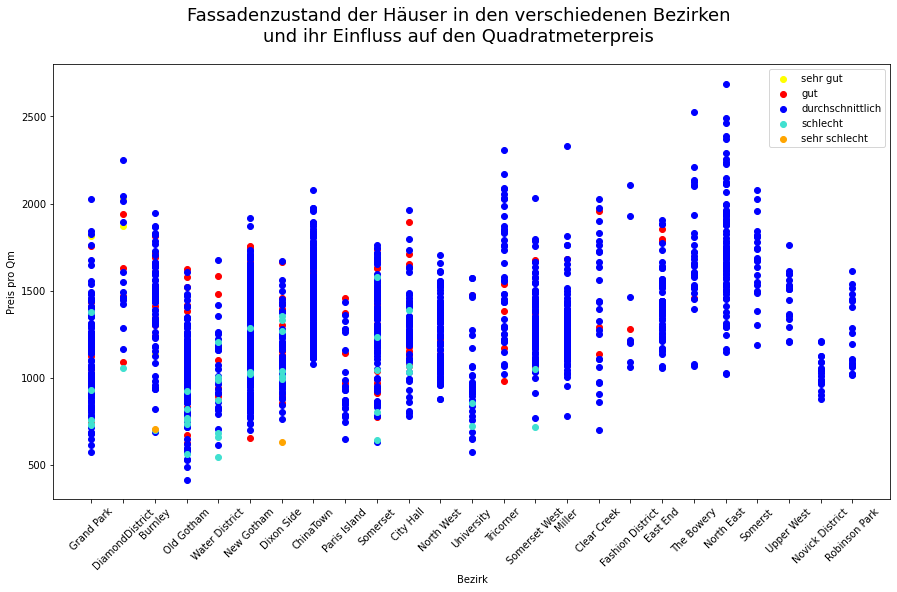

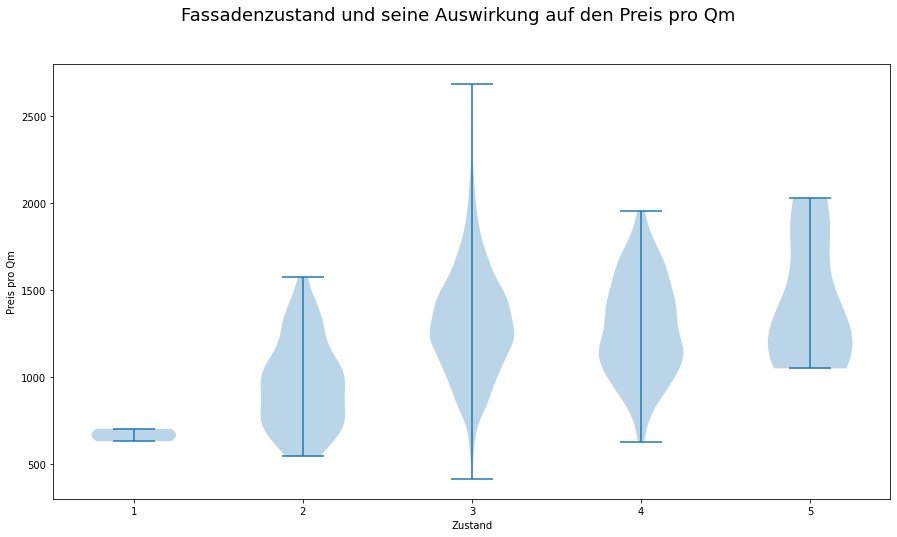

In [18]:
house_1 = housing_data[housing_data["Zustand Fassade"] == 1]
house_2 = housing_data[housing_data["Zustand Fassade"] == 2]
house_3 = housing_data[housing_data["Zustand Fassade"] == 3]
house_4 = housing_data[housing_data["Zustand Fassade"] == 4]
house_5 = housing_data[housing_data["Zustand Fassade"] == 5]


plt.figure(figsize=(15,8))

plt.scatter(house_5["Bezirk"],house_5["Preis"]/house_5["Wohnflaeche in qm"], c="yellow")
plt.scatter(house_4["Bezirk"],house_4["Preis"]/house_4["Wohnflaeche in qm"], c="red")
plt.scatter(house_3["Bezirk"],house_3["Preis"]/house_3["Wohnflaeche in qm"], c="blue")
plt.scatter(house_2["Bezirk"],house_2["Preis"]/house_2["Wohnflaeche in qm"], c="turquoise")
plt.scatter(house_1["Bezirk"],house_1["Preis"]/house_1["Wohnflaeche in qm"], c="orange")

plt.suptitle("Fassadenzustand der Häuser in den verschiedenen Bezirken\nund ihr Einfluss auf den Quadratmeterpreis",fontsize=18)
plt.xlabel("Bezirk")
plt.ylabel("Preis pro Qm")
plt.xticks(rotation=45)
plt.legend(["sehr gut", "gut",
            "durchschnittlich","schlecht","sehr schlecht"])
plt.show()

key = "Zustand Fassade"
rows = ["Preis pro Qm"]
quality = np.sort(housing_data[key].unique())

for row in rows:
    fig= plt.figure(figsize=(15,8))
    data = [None]*len(quality)
    for i in range(len(quality)):
        data[i] = housing_data[housing_data[key] == quality[i]][row.replace(" ","").replace("Q","q")]

    plt.violinplot(data)
    plt.suptitle("Fassadenzustand und seine Auswirkung auf den " + row,fontsize=18)
    plt.xlabel("Zustand")
    plt.ylabel(row)
    plt.show()

Die meisten Fassaden in Gotham befinden sich in einem Zustand von 3 oder 4.<br>
Größere preisliche Unterschiede lassen sich nur zwischen Zuständen 1 2 und 5 erkennen.

# Kellerfläche

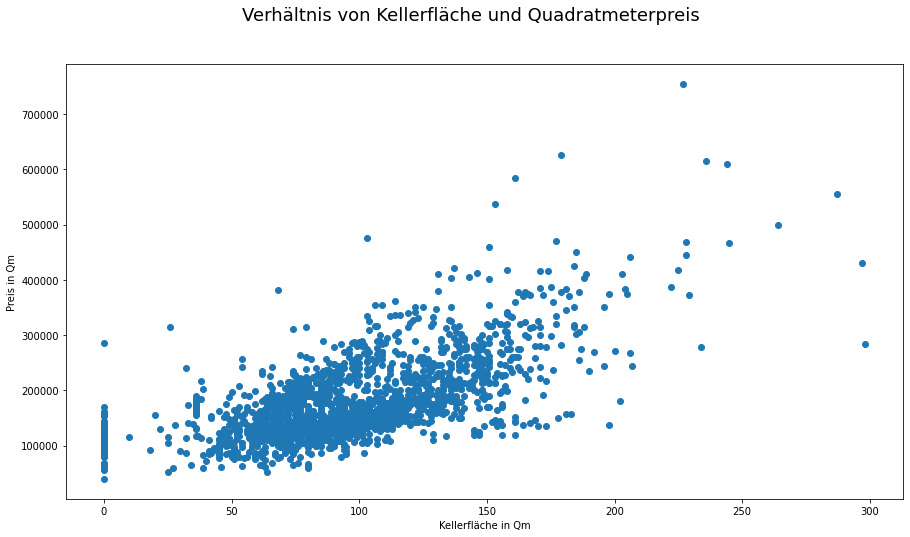

In [21]:
plt.figure(figsize=(15,8))

plt.scatter(housing_data["Kellerflaeche in qm"],housing_data["Preis"]/housing_data["Wohnflaeche in qm"], c="red")

plt.suptitle("Verhältnis von Kellerfläche und Quadratmeterpreis",fontsize=18)
plt.xlabel("Kellerfläche in Qm")
plt.ylabel("Preis in Qm")
plt.show()

Falls eine Immobilie eine größere Kellerfläche hat, kann sie einen höheren Marktwert erreichen.<br>
Es gibt viele Häuser die keinen Keller besitzen. Diese sind meist preislich günstiger.<br>

# Wohnfläche

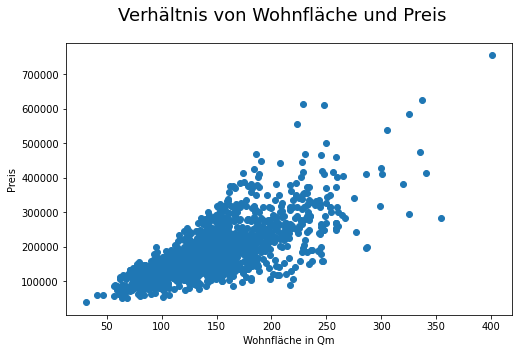

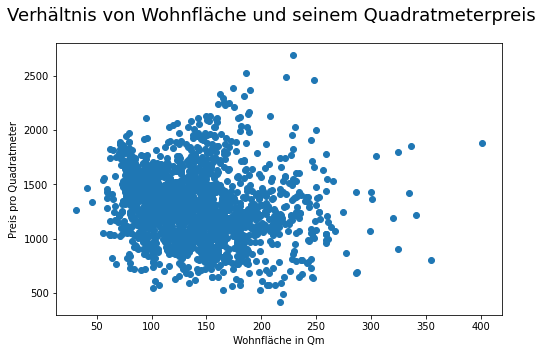

In [20]:
plt.figure(figsize=(8,5))
plt.scatter(housing_data["Wohnflaeche in qm"], housing_data["Preis"])

plt.suptitle("Verhältnis von Wohnfläche und Preis",fontsize=18)
plt.xlabel("Wohnfläche in Qm")
plt.ylabel("Preis")
plt.show()

plt.figure(figsize=(8,5))
plt.scatter(housing_data["Wohnflaeche in qm"], housing_data["Preis"]/housing_data["Wohnflaeche in qm"])

plt.suptitle("Verhältnis von Wohnfläche und seinem Quadratmeterpreis",fontsize=18)
plt.xlabel("Wohnfläche in Qm")
plt.ylabel("Preis pro Quadratmeter")
plt.show()

Der Immobilienpreis und die Wohnfläche des Gebäudes sind voneinander abhängig.<br>
Der Preis pro Quadratmeter ist nicht von der Wohnungsgröße abhängig.

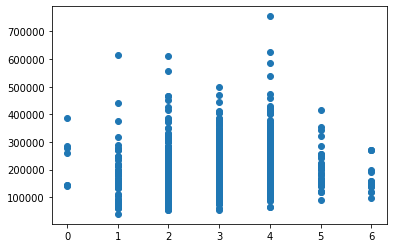

In [27]:
plt.scatter(housing_data["Schlafzimmer"], housing_data["Preis"])